In [18]:
import numpy as np
def linear_model(
    n_samples: int, n_features: int, noise: float = 0.05, random_state: int = 1
):
    """
    Generate random samples and labels for a linear regression model.

    Parameters:
    - n_samples (int): Number of samples to generate.
    - n_features (int): Number of features.
    - noise (float, optional): Standard deviation of Gaussian noise added to the labels (default is 0.05).
    - random_state (int, optional): Seed for random number generation (default is 1).

    Returns:
    - features (numpy.ndarray): Generated random feature matrix of shape (n_samples, n_features).
    - y (numpy.ndarray): Generated labels using a linear combination of features and weights with added noise.

    """

    np.random.seed(random_state)

    # Generate random samples and coefficients
    features = np.random.randn(n_samples, n_features)
    weights = np.random.uniform(-1, 1, n_features)
    bias = np.random.uniform(-1, 1, n_features)  # TODO bias not used
    # Compute y using linear combination of X and coef
    y = np.dot(features, weights) + noise * np.random.randn(n_samples)

    return features, y


def noise_model(n: int, k: int, noise_level: float):
    """
    Generate uncertainty features and standard deviation for the heteroscedastic noise.

    Parameters:
    - n (int): Number of samples to generate.
    - k (int): Number of features.
    - noise_level (float): Standard deviation of the error of the model which generates the heteroscedastic noise.

    Returns:
    - features (numpy.ndarray): Generated random feature matrix of shape (n, k).
    - std (numpy.ndarray): Generated standard deviation of the heteroscedastic noise of shape (n,).

    Example:
    features, labels = noise_model(n=100, k=3, noise_level=0.1)
    """
    # Generate random noise
    noise = np.random.normal(0, noise_level, n)

    # Generate random weights for linear and quadratic terms
    bias = np.random.uniform(0.5, 1, 1) * np.random.choice([-1, 1], 1)
    weights_linear = np.random.uniform(0.5, 1, k) * np.random.choice([-1, 1], k)
    weights_quadratic = np.random.uniform(0.5, 1, k) * np.random.choice([-1, 1], k)

    # Generate random weights for interaction terms
    weights_interaction = np.random.uniform(
        0.5, 1, int(k * (k - 1) / 2)
    ) * np.random.choice([-1, 1], int(k * (k - 1) / 2))

    # Generate random features
    features = np.random.normal(0, 1, (n, k))

    # Compute linear and quadratic contributions
    labels = (
        np.dot(features, weights_linear)
        + np.dot(features**2, weights_quadratic)
        + bias
    )

    # Compute interaction terms contributions using broadcasting
    i, j = np.triu_indices(k, 1)  # Get upper triangular indices, excluding the diagonal
    interaction_terms = features[:, i] * features[:, j]
    labels += interaction_terms @ weights_interaction

    # Add noise
    labels += noise

    stds = np.abs(labels)

    return features, stds


def simple_noise_model(n: int, k: int, noise_level: float):
    features = np.random.normal(0, 1, (n, k))
    stds = noise_level * np.abs(np.sum(features, axis=1))
    return features, stds


def get_data(
    remake_data: bool,
    n_train: int,
    n_test: int,
    noise_scaler: float,
    save_dir: str,
    identifier: str,
    k_mean: int = 70,
    k_noise: int = 5,
    k_mixed: int = 0,
    random_state: int = 1,
):
    """
    Generate or load synthetic dataset for training, validation, and testing of an uncertainty aware model.

    Parameters:
    - remake_data (bool): If True, regenerate the dataset. If False, load the dataset from a file.
    - n_train (int): Number of training samples (includes validation samples, as we use validation for early stopping)
    - n_test (int): Number of testing samples.
    - noise_scaler (float): Scaling factor for the heteroscedastic noise in the dataset.
    - save_dir (str): Directory where the dataset should be saved or loaded from.
    - identifier (str): Unique identifier for the dataset file.
    - k_mean (int, optional): Number of features for the linear model (default is 70).
    - k_noise (int, optional): Number of features for the noise model (default is 5).
    - k_mixed (int, optional): Number of features for the mixed model (default is 5).
    - random_state (int, optional): Seed for random number generation (default is 1).

    Returns:
    - x_train (torch.Tensor): Training features as a torch tensor.
    - x_val (torch.Tensor): Validation features as a torch tensor.
    - x_test (torch.Tensor): Testing features as a torch tensor.
    - y_train (torch.Tensor): Training labels as a torch tensor.
    - y_val (torch.Tensor): Validation labels as a torch tensor.
    - y_test (torch.Tensor): Testing labels as a torch tensor.
    - y_means (numpy.ndarray): Mean values used for scaling the labels.
    - y_stds (numpy.ndarray): Standard deviation values used for scaling the labels.
    - feature_names (list of str): Names of the features in the dataset.

    """
    n = n_train + n_test
    if remake_data:
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import StandardScaler

        model_error_linear = 0.00
        model_error_noise = 0.00

        # generate the mean features and mean labels
        data = linear_model(
            n, k_mean, noise=model_error_linear, random_state=random_state
        )
        inputs = data[0]
        output = data[1]
        data_noise = noise_model(n, k_noise, model_error_noise)

        # generate the heteroscedastic noise based on output of the noise model
        noise = np.random.normal(loc=0.0, scale=noise_scaler * data_noise[1], size=n)
        output = output + noise
        feature_names = [f"feature_{i}" for i in range(inputs.shape[1])] + [
            f"noise_feature_{i}" for i in range(data_noise[0].shape[1])
        ]
        inputs = np.concatenate((inputs, data_noise[0]), axis=1)


        if k_mixed > 0:
            data_mixed = noise_model(
                n, k_mixed, model_error_noise
            )
            # standardize the data
            location_change = (data_mixed[1]-np.mean(data_mixed[1]))/np.std(data_mixed[1])
            # scale to the same range as the original data for meaningful contribution
            shift = np.random.normal(loc=location_change*1.2, scale=noise_scaler*data_mixed[1], size=n) 
            inputs = np.concatenate((inputs, data_mixed[0]), axis=1)
            output_basemodel = location_change.copy()
            output = output + shift
            feature_names += [f"mixed_feature_{i}" for i in range(data_mixed[0].shape[1])]


        x_train, x_test, y_train, y_test, _, noise_std_test, _, y_denoised = train_test_split(
            inputs, output, data_noise[1]+noise_scaler*data_mixed[1], output_basemodel, test_size=n_test, random_state=1
        )  # We need the noise_std_test to compare with the pnn uncertainties
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=0.2, random_state=1
        )

        # normalize target

        y_train = y_train.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        scaler = StandardScaler()
        y_train = scaler.fit_transform(y_train)
        y_val = scaler.transform(y_val)
        y_test = scaler.transform(y_test)
        y_denoised_test = scaler.transform(y_denoised.reshape(-1, 1)).flatten()
        y_train = y_train.flatten()
        y_val = y_val.flatten()
        y_test = y_test.flatten()

        y_means = scaler.mean_
        y_stds = scaler.scale_
        np.savez(
            f"{save_dir}data_{identifier}.npz",
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            x_val=x_val,
            y_val=y_val,
            y_means=y_means,
            y_stds=y_stds,
            noise_std_test=noise_std_test,
            feature_names=feature_names,
            y_denoised_test=y_denoised_test.flatten(),
        )
    else:
        npz = np.load(f"{save_dir}data_{identifier}.npz")
        x_train = npz["x_train"]
        y_train = npz["y_train"]
        x_val = npz["x_val"]
        y_val = npz["y_val"]
        x_test = npz["x_test"]
        y_test = npz["y_test"]
        y_means = npz["y_means"]
        y_stds = npz["y_stds"]
        noise_std_test = npz["noise_std_test"]
        feature_names = npz["feature_names"]
        y_denoised_test = npz["y_denoised_test"]
    return (
        x_train,
        x_val,
        x_test,
        y_train,
        y_val,
        y_test,
        y_means,
        y_stds,
        feature_names,
        noise_std_test,
        y_denoised_test
    )


In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, y_means, y_stds, feature_names, noise_std_test, y_denoised_test = get_data(remake_data=True, n_train=1000, n_test=10000, noise_scaler=0.5, save_dir="./", identifier="deleteme", k_mean=0, k_noise=0, k_mixed=1, random_state=42)

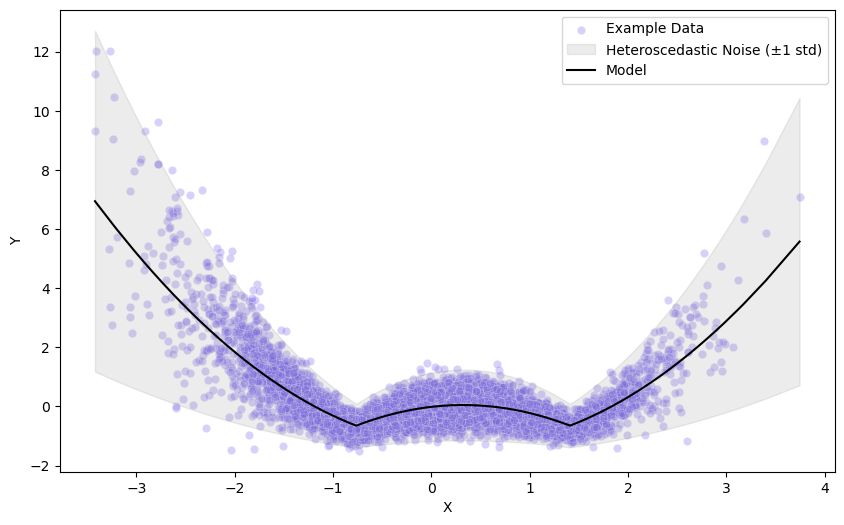

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming x_test, y_test, noise_std_test, and y_denoised_test are already defined
plt.figure(figsize=(10, 6))

# Create the dataframe for scatter plot
df = pd.DataFrame(x_test)
df["y"] = y_test
df["noise_std"] = noise_std_test

# Scatter plot with noise_std as the hue
sns.scatterplot(data=df, x=0, y="y", color="mediumslateblue", alpha=0.3, label="Example Data")

# Sort x_test and y_denoised_test by x_test values
sorted_indices = np.argsort(x_test.squeeze())
x_test_sorted = x_test[sorted_indices]
y_denoised_test_sorted = y_denoised_test[sorted_indices]
noise_std_sorted = noise_std_test[sorted_indices]

# Calculate upper and lower bounds for the standard deviation (± noise_std)
y_upper = y_denoised_test_sorted + noise_std_sorted
y_lower = y_denoised_test_sorted - noise_std_sorted

# Plot the denoised data with fill between for ± noise_std
plt.fill_between(x_test_sorted.squeeze(), y_lower, y_upper, color='gray', alpha=0.15, label='Heteroscedastic Noise (±1 std)')
plt.plot(x_test_sorted, y_denoised_test_sorted, color="black", label="Model")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


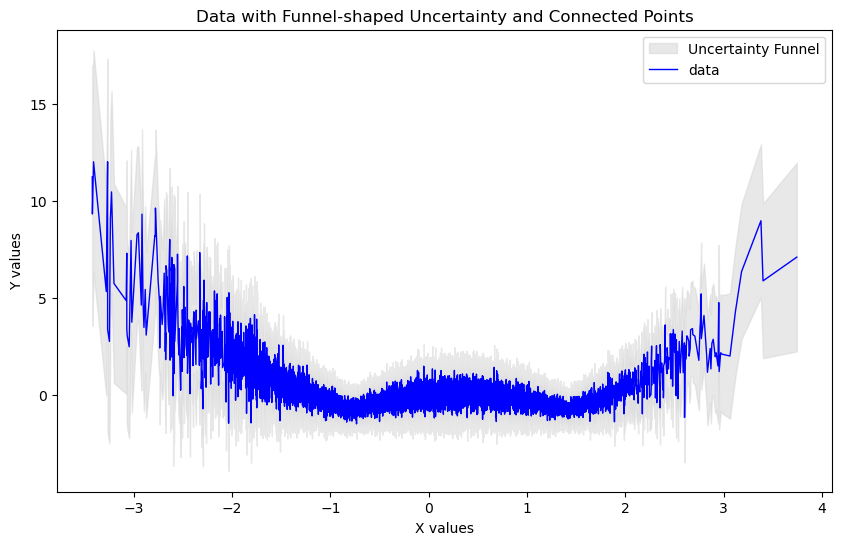

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure your data is in the correct shape
# x_test, y_test, noise_std_test should already be defined

# Sort data by x_test values to ensure proper plotting order
sorted_indices = np.argsort(x_test.squeeze())  # Get sorted indices based on x_test
x_sorted = x_test.squeeze()[sorted_indices]
y_sorted = y_test[sorted_indices]
noise_sorted = noise_std_test[sorted_indices]

# Calculate the upper and lower bounds of the funnel based on the error bars
y_upper = y_sorted + noise_sorted
y_lower = y_sorted - noise_sorted

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the "funnel" by filling between the upper and lower bounds
plt.fill_between(x_sorted, y_lower, y_upper, color='lightgray', alpha=0.5, label="Uncertainty Funnel")

# Plot the data points with error bars
#plt.errorbar(x_sorted, y_sorted, yerr=noise_sorted, fmt="o", label="True")

# Connect the data points with a line
plt.plot(x_sorted, y_sorted, color='blue', linewidth=1, label="data")

# Labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Data with Funnel-shaped Uncertainty and Connected Points')

# Show legend
plt.legend()

# Show the plot
plt.show()
